In [35]:
import matplotlib.pyplot as plt
import numpy as np
import xyStripTools
import root_pandas as rp
import pandas as pd
from ROOT import TFile, TVector3, TMath
import uproot


from xyStripTools import T_off
from xyStripTools import plot_track

In [36]:
# The time offset distributions measured for all quadrants of all detectors
# See the Micromegas nimA paper for more information
T_off


#set the drift speed [cm/ns]
v_drift = 0.0008


# Load Raw Helium Recoil Simulation

In [37]:
# Path to root file 
# these simulation are very low energy
# It would be interesting to see this in higher energy simulation for He:CO2
file_path = './data/He_in_70He30CO2_5-24keVr.root'

f = TFile(file_path, 'read')
mytree=f.Get('recoils')
nentry = mytree.GetEntries()


tracks = pd.DataFrame(columns = ['track',"N_electron"])

for n in range(nentry):
    event = mytree.GetEntry (n)

    track = []

    #draw random direction
    to_dir = xyStripTools.random_three_vector2()
    
    for electron in mytree.electron_x:

        # Get position in cm
        charge = 0.1*electron.Vect()
        
        #rotate the charge positions to the random direction
        charge.RotateY(-(0.5*TMath.Pi()-to_dir.Theta()))
        charge.RotateZ(to_dir.Phi())

        # I add 1 cm to the z-coordinat so that they start at position (0,0,1) in tpc coordinates (i.e. 0.5 cm of drift)
        track += [np.array([charge[0],charge[1],charge[2]+0.5])]

    tracks = tracks.append({'track' : np.array(track), 'N_electron' : len(track) }, ignore_index = True)





In [38]:
tracks 

,track,N_electron
0,"[[-0.011933803892306544, -0.004595298305588069...",488
1,"[[-0.015115225487161236, 0.011312421226368156,...",96
2,"[[-0.003803507304222905, 0.009852967247796926,...",292
3,"[[-0.01360621409579741, -0.009483314139824332,...",237
4,"[[0.001327166916388991, 0.008191309637506652, ...",111
...,...,...
1995,"[[-0.016495370143825232, -0.02240544114071033,...",367
1996,"[[0.005925048981187798, 0.013735662455335293, ...",344
1997,"[[-0.0016398826349255484, 0.003249573104654438...",118
1998,"[[-0.025058511289965897, -0.006006991302761659...",389


## Plot example of a track

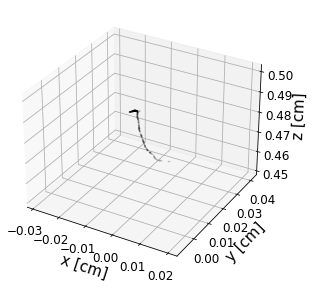

In [39]:
track_index = 2

track = tracks.iloc[track_index].track
plot_track(track)

# Add diffusion

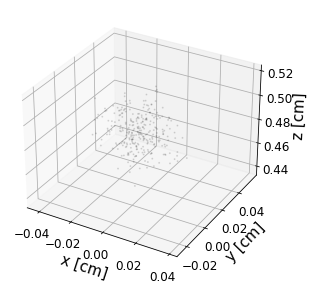

In [40]:
# The paramters, in order, are:
# tracks, a dataframe with the raw track info
# Transverse diffusion coefficent for 70% He 30% CO2 from Magboltz [cm/sqrt(cm)]
# Longitudinal diffusion coefficent for 70% He 30% CO2 from Magboltz [cm/sqrt(cm)]
tracks = xyStripTools.add_diff(tracks, DTrans = 0.0135, DLong = 0.0129)

# Plot a Track
track = tracks.iloc[track_index]["diff_track"]
plot_track(track)

# Simulate readout


Simulates a 10 cm x 10 cm readout plane in the xy-plane centered at the origin

In [41]:
# the parameters, in order, are:
# peaking time [ns]
# digitization time [ns] 
# pitch of the x strips [um]
# pitch of the y strips [um]
# Threshold of x strips [No. electrons]
# Threshold of y strips [No. electrons]
# Charge sharing [lower strips / upper strips]
# Gain - extrapolating from PHA curve
# drift speed cm/ns
# Include charge integration effect.
# z resolution in cm, must be specified if Charge_integration = False
# Electronic gain in x [mV/fC]
# Electronic gain in y [mV/fC]
hits = xyStripTools.sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = 200, pitch_y = 200,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = 0.62, Gain = 60000, v_drift = v_drift, Charge_integration = True, DL = 1.2, pitch_z = 0.02, G_x = 9.0, G_y = 4.5)
tracks = pd.concat([tracks,hits],axis=1)
tracks.head()

,track,N_electron,diff_track,strips_x,strips_y,times_x,times_y,electrons_x,electrons_y,adcs0,adcs1,strips0,strips1,times0,times1
0,"[[-0.011933803892306544, -0.004595298305588069...",488,"[[-0.01367009478093065, -0.002486278296550214,...","[-0.07000000000010509, -0.050000000000105516, ...","[-0.050000000000105516, -0.030000000000105942,...","[591.1230947089853, 591.8910160951857, 605.847...","[586.3418294293881, 595.402095499796, 613.7642...","[229629.6296296296, 2686666.6666666665, 424814...","[888888.8888888889, 5629629.62962963, 8407407....","[331.11698576731015, 1023.0, 1023.0, 1023.0, 1...","[640.8715853560842, 1023.0, 1023.0, 1023.0]","[246, 247, 248, 249, 250]","[247, 248, 249, 250]","[591.1230947089853, 591.8910160951857, 605.847...","[586.3418294293881, 595.402095499796, 613.7642..."
1,"[[-0.015115225487161236, 0.011312421226368156,...",96,"[[-0.02184553425488079, 0.014229493516863473, ...","[-0.030000000000105942, -0.010000000000106368,...","[-0.010000000000106368, 0.009999999999893205, ...","[610.7640990374914, 617.5421808255542, 619.116...","[618.4567876864554, 616.5705158129653, 614.229...","[321481.48148148146, 1423703.7037037036, 45925...","[999999.9999999999, 2222222.222222222, 333333....","[463.5637800742343, 1023.0, 662.2339715346203]","[720.9805335255948, 1023.0, 240.3268445085316]","[248, 249, 250]","[249, 250, 251]","[610.7640990374914, 617.5421808255542, 619.116...","[618.4567876864554, 616.5705158129653, 614.229..."
2,"[[-0.003803507304222905, 0.009852967247796926,...",292,"[[-0.00019740372433491417, 0.00172883419412191...","[-0.030000000000105942, -0.010000000000106368,...","[-0.010000000000106368, 0.009999999999893205, ...","[600.3294747196095, 599.1825194242977, 608.184...","[618.6270747712531, 607.0539857931328, 589.333...","[344444.44444444444, 4225185.185185185, 208962...","[999999.9999999999, 6185185.185185185, 3407407...","[496.6754786509653, 1023.0, 1023.0]","[720.9805335255948, 1023.0, 1023.0, 160.217896...","[248, 249, 250]","[249, 250, 251, 252]","[600.3294747196095, 599.1825194242977, 608.184...","[618.6270747712531, 607.0539857931328, 589.333..."
3,"[[-0.01360621409579741, -0.009483314139824332,...",237,"[[-0.02477764351883825, -0.010029176944716197,...","[-0.050000000000105516, -0.030000000000105942,...","[-0.030000000000105942, -0.010000000000106368,...","[607.3855164489242, 615.9890549373056, 623.241...","[617.5840642883534, 619.9381121794655, 624.673...","[183703.70370370368, 2043703.7037037036, 26407...","[1962962.962962963, 5222222.222222222, 1555555...","[264.8935886138481, 1023.0, 1023.0, 794.680765...","[1023.0, 1023.0, 1023.0]","[247, 248, 249, 250]","[248, 249, 250]","[607.3855164489242, 615.9890549373056, 623.241...","[617.5840642883534, 619.9381121794655, 624.673..."
4,"[[0.001327166916388991, 0.008191309637506652, ...",111,"[[-0.0016624147897126508, 0.010068779713034093...","[-0.010000000000106368, 0.009999999999893205, ...","[-0.010000000000106368, 0.009999999999893205, ...","[610.6155319792011, 609.2266280322183, 618.793...","[613.9256937285595, 609.670915160756, 604.3294...","[987407.4074074073, 1446666.6666666665, 68888....","[814814.8148148147, 3074074.0740740737, 222222...","[1023.0, 1023.0, 99.33509573019306]","[587.465619909744, 1023.0, 160.21789633902105]","[249, 250, 251]","[249, 250, 251]","[610.6155319792011, 609.2266280322183, 618.793...","[613.9256937285595, 609.670915160756, 604.3294..."


# Perform 3D Reconstruction

[16.30558894 15.15863364 24.1608391 ]


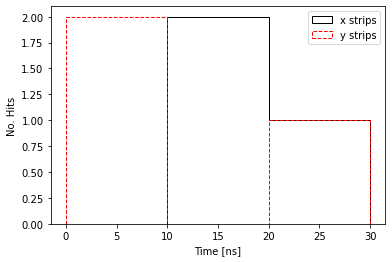

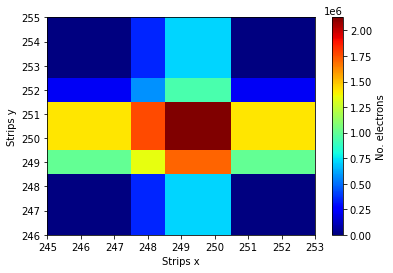

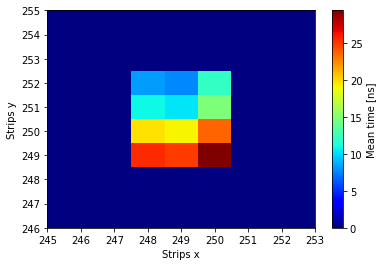

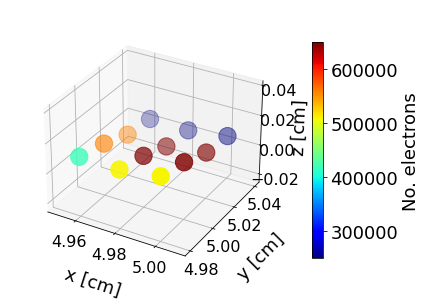

In [42]:

# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

# Look at a single event after the cut
test_event = tracks.iloc[track_index]
# Make a TrackTools object for the event
dsp = xyStripTools.TrackTools(event = test_event, Mult_factor = 1.0, gain_x=9, gain_y=4.5, v_drift=v_drift*10000)

# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma)

# Make voxel plot

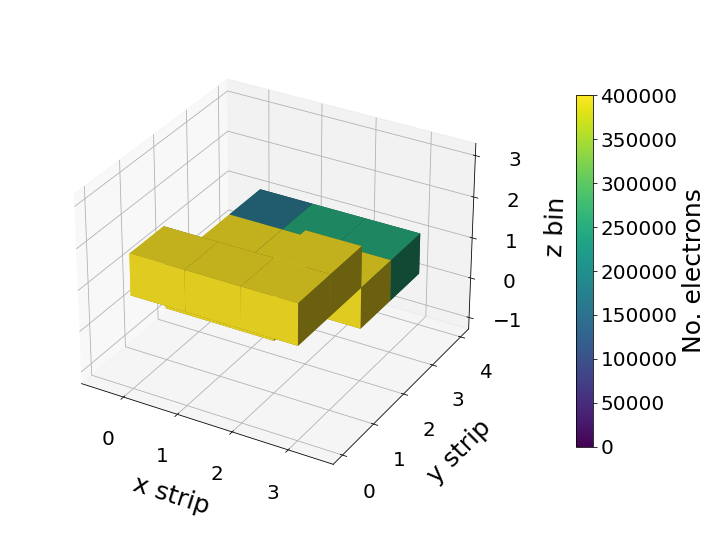

In [43]:
xyStripTools.make_voxel_plot(x,y,z,c)